# **How often are appointments missed in the SNEE footprint?**

- This is required so that we can model the number of appointments missed, as this will require the patient to re-attend in the model at a later date.

- Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

- [using multiple years] Are the missed appointment %ages consistent over time (compare years, statistical tests)?

- Across staff groups & Sub-ICB, are some appointments more likely to be missed?

- Using the analysis from the above, what is the mean likelihood that someone (from a combination of)
    - Sub-ICB
    - Staff type
    - Appointment type
    - Will not attend?

- Suggest an appropriate distribution to sample from, to determine if a patient with the above appointment will attend.
Persist the distribution information from 5. to a yaml file.

### **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from schemas import DataCatalog
import constants as const
import seaborn as sns

### **Loading the datalog**

In [2]:
# Load data catalog
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

### **Loading the dataset 'NHS GP Appointments by Region' for appointments data**

In [121]:
gp_appts_catalog_entry = catalog.single_data_sources[0]
gp_appts_df = gp_appts_catalog_entry.load()
print(gp_appts_catalog_entry.zip_file.namelist())

#Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

combined_df = pd.concat(dfs, axis=0)
combined_df.head()

['Regional_CSV_WYorks.csv', 'Regional_CSV_Sussex.csv', 'Regional_CSV_SurreyHearts.csv', 'Regional_CSV_SuffolkNEEssex.csv', 'Regional_CSV_StaffsStoke.csv', 'Regional_CSV_Somerset.csv', 'Regional_CSV_ShropsTelfordWrekin.csv', 'Regional_CSV_SYorks.csv', 'Regional_CSV_SWLondon.csv', 'Regional_CSV_SELondon.csv', 'Regional_CSV_NottinghamNotts.csv', 'Regional_CSV_Northamptonshire.csv', 'Regional_CSV_NorfolkWaveney.csv', 'Regional_CSV_NWLondon.csv', 'Regional_CSV_NENCumbria.csv', 'Regional_CSV_NELondon.csv', 'Regional_CSV_NCLondon.csv', 'Regional_CSV_MidSEssex.csv', 'Regional_CSV_Lincolnshire.csv', 'Regional_CSV_LeicesterLshire.csv', 'Regional_CSV_LancsSCumbria.csv', 'Regional_CSV_KentMedway.csv', 'Regional_CSV_HumberNYorks.csv', 'Regional_CSV_HertfordshireWEssex.csv', 'Regional_CSV_HereWorcs.csv', 'Regional_CSV_HampshireIoW.csv', 'Regional_CSV_Gloucestershire.csv', 'Regional_CSV_GManchesterHSCP.csv', 'Regional_CSV_FrimleyHealth.csv', 'Regional_CSV_Dorset.csv', 'Regional_CSV_Devon.csv', 'Regio

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,1 Day,1999
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,15 to 21 Days,329
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,2 to 7 Days,4194
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,22 to 28 Days,212
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,8 to 14 Days,1101


In [122]:
needed_cols = ['ICB_NAME','SUB_ICB_LOCATION_ONS_CODE','APPOINTMENT_MONTH','APPT_STATUS','COUNT_OF_APPOINTMENTS']
combined_df_copy = combined_df[needed_cols].copy()

In [123]:
#Replacing months values to FY- years
combined_df_copy['APPOINTMENT_MONTH'] = combined_df_copy['APPOINTMENT_MONTH'].replace({'APR2021':'FY2021', 'MAY2021':'FY2021', 'JUN2021':'FY2021', 'JUL2021':'FY2021', 'AUG2021':'FY2021', 'SEP2021':'FY2021',
                                                                                       'OCT2021':'FY2021', 'NOV2021':'FY2021', 'DEC2021':'FY2021', 'JAN2022':'FY2021', 'FEB2022':'FY2021', 'MAR2022':'FY2021',
                                                                                       'APR2022':'FY2022', 'MAY2022':'FY2022', 'JUN2022':'FY2022', 'JUL2022':'FY2022', 'AUG2022':'FY2022', 'SEP2022':'FY2022',
                                                                                       'OCT2022':'FY2022', 'NOV2022':'FY2022', 'DEC2022':'FY2022', 'JAN2023':'FY2022', 'FEB2023':'FY2022', 'MAR2023':'FY2022',
                                                                                       'APR2023':'FY2023', 'MAY2023':'FY2023', 'JUN2023':'FY2023', 'JUL2023':'FY2023', 'AUG2023':'FY2023'})

combined_df_copy = combined_df_copy.loc[combined_df_copy['APPOINTMENT_MONTH']!='MAR2021']
combined_df_copy['APPOINTMENT_MONTH'].unique()

array(['FY2021', 'FY2022', 'FY2023'], dtype=object)

### **Creating separate DF's for attended and not attended appointments**

In [ ]:
attended_df = combined_df_copy.loc[combined_df['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS'])
#attended_df = attended_df.groupby['ICB_NAME','APPOINTMENT_MONTH'].mean().round(4)
#National_average_attended = attended_df['COUNT_OF_APPOINTMENTS'].mean()
#print(f'The national average for attended appointments is: {National_average_attended}')
attended_df.head()

In [130]:
do_not_attend_df = combined_df_copy.loc[combined_df['APPT_STATUS'] != 'Attended'].drop(columns=['SUB_ICB_LOCATION_ONS_CODE','APPOINTMENT_MONTH','APPT_STATUS']).groupby('ICB_NAME').sum().round(4)
National_average_DNA = do_not_attend_df['COUNT_OF_APPOINTMENTS'].mean()
print(f'The national average for did not attend or unknown appointments is: {National_average_DNA}')
do_not_attend_df.head()

IndexError: indices are out-of-bounds

### **Plotting the attended vs non-attended lineplot**

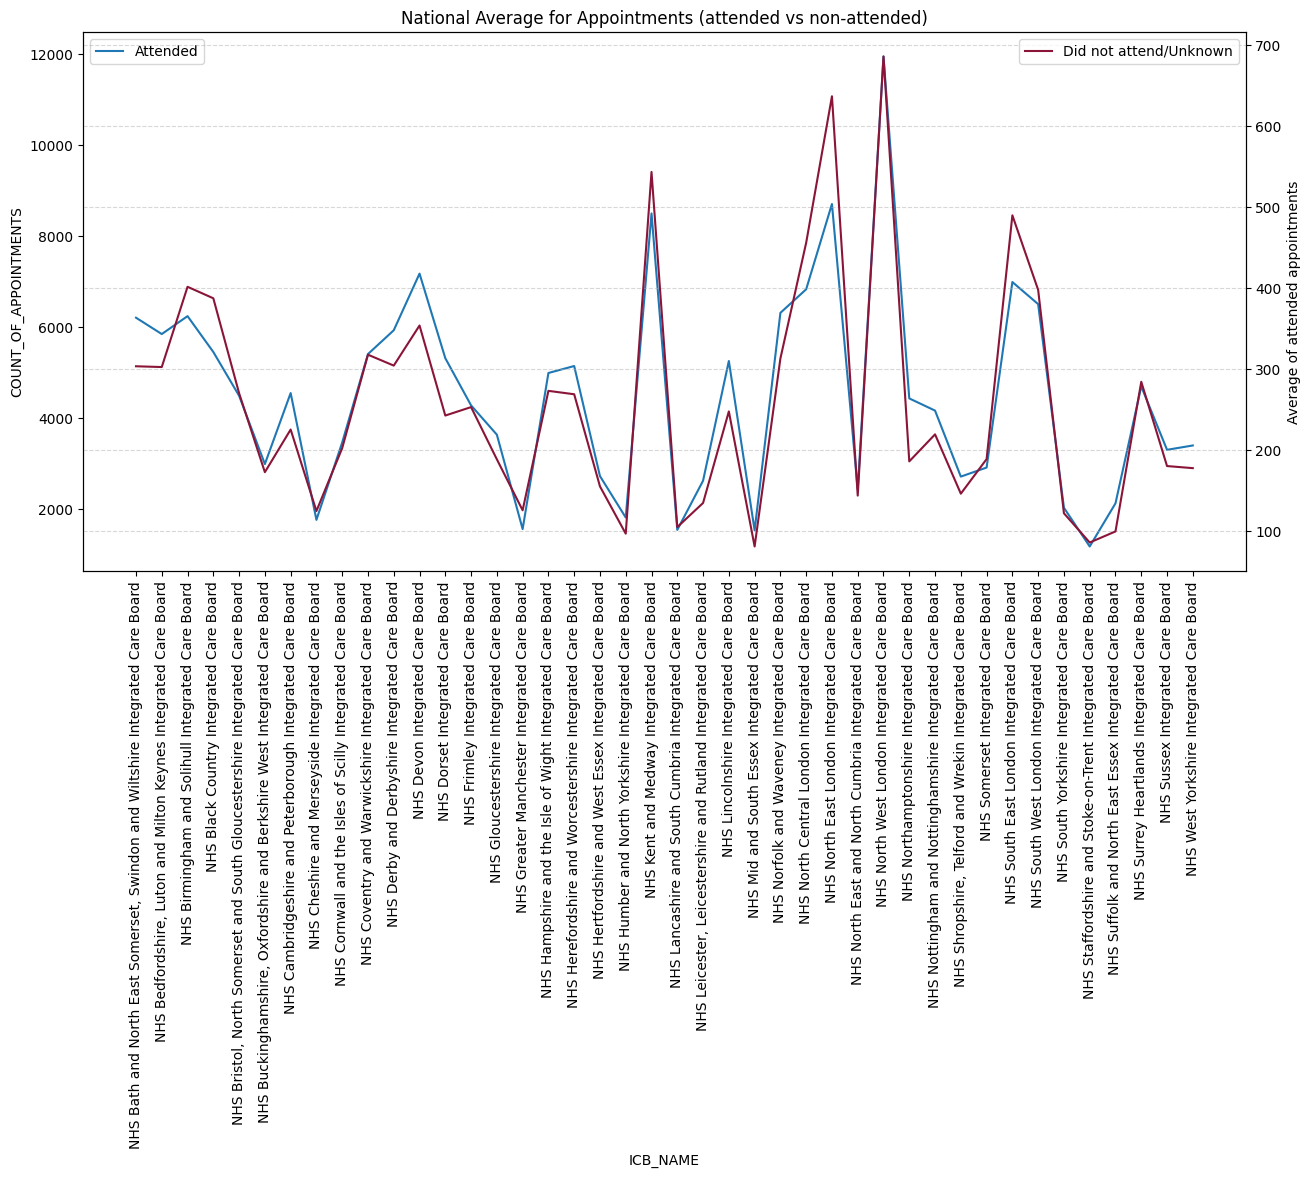

In [103]:
#Plotting the lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
ax = sns.lineplot(x=attended_df.index, y='COUNT_OF_APPOINTMENTS', data=attended_df, label = 'Attended')
#Creating secondary y-axis
ax2 = ax.twinx()
sns.lineplot(x=do_not_attend_df.index, y='COUNT_OF_APPOINTMENTS', data=do_not_attend_df, ax=ax2, color='#8A1538', label = 'Did not attend/Unknown')

ax2.set_label('Average of did not attend Appointments')

plt.xlabel('ICBs')
plt.ylabel('Average of attended appointments')
plt.title('National Average for Appointments (attended vs non-attended)')
plt.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

### **Creating separte df's for FY- 2021, 2022 & 2023**

#### **FY-2021**

In [107]:
#Filtering the data for FY2021-22
fy2021 = ['APR2021','MAY2021', 'JUN2021', 'JUL2021', 'AUG2021', 'SEP2021', 'OCT2021', 'NOV2021', 'DEC2021', 'JAN2022', 'FEB2022', 'MAR2022']
fy_2021_df = combined_df_copy[combined_df_copy['APPOINTMENT_MONTH'].isin(fy2021)]

#Filtering the data for FY2022-23
fy2022 = ['APR2022','MAY2022', 'JUN2022', 'JUL2022', 'AUG2022', 'SEP2022', 'OCT2022', 'NOV2022', 'DEC2022', 'JAN2023', 'FEB2023', 'MAR2023']
fy_2022_df = combined_df_copy[combined_df_copy['APPOINTMENT_MONTH'].isin(fy2022)]
